# Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

**План занятия:**

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Что такое эмбединги? 


Эмбединги интерпретируется как "вложение". Например, есть параметр цвет: RGBKW - разряженный вектор 01000. Эмбединг это как раз то, что позволяет перейти к другому пространству и сжать данный вектор.

*PCA*, *SVD* - методы из предыдущих курсов это и есть эмбединг.

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга. Если же более формально, то: 

**Сегментация клиентской базы** — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](images/payments1.png "Payments2")

#### 2. по психотипам

![ab_split](images/psycho.png "Psycho")

#### 3. по платежам

![ab_split](images/payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](images/uplift.png "Uplift")

#### 5. по интересам

![ab_split](images/interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

LDA - Latent Dirichlet allocation

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

![lda](images/lda_simple.png "LDA")

ист. https://habr.com/ru/company/surfingbird/blog/230103/

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](images/tm1.png "TM1")

Цель LDA - Latent Dirichlet allocation:

* Пересчитываем слова и определяем апостериорную вероятность принадлежности слова тексту $F=p(w|d)$ - Получили зеленую матрицу
* Дальше начинаем придумывать за счет итерационной подгонки синюю $\Phi$ и желтую $\Theta$ матрицу. Синяя матрица - как мы пытаемся воспроизвести вероятность принадлежность слова к тему (топику) и желтая матрица - вероятность принадлежности темы к документу.

Реализации:

* scikit-learn LatentDirichletAllocation
* webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/

## Переходим к практике

### 1. Загрузка данных

Сейчас будет заниматься интерпретацией русского текста - это очень сложная задача. Русский язык не структурный, сложный. Мы будем пользоваться библиотеками:

1. razdel - проект "Наташа", токенизация русских текстов. Очень известный пакет.
2. pymorphy2 - яндексовский проект. Стандарт по разборке русского языка. 
3. pyLDAvis - взаимодействие с LDA (инструменты тематического анализа)

Данные сегодня также объемные materials.csv. Лежат в рабочей директории.

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
news.shape

(27000, 2)

Загрузим пользователей и списки последних прочитанных новостей

In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 2. Получаем векторное представление новостей 

Статьи представляем в виде векторов. Вектор - вероятность содержания каждой темы. Количество тем, которые могут содержаться в статье, задается самостоятельно произвольно. Выбор количества тем - чистый подбор.

#### 2.1 Предобработка

Проводим токенизацию, чистку, лемминизация (МорфАналайзер)

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [6]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
import nltk
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [7]:
# скачиваем stopwords.txt
# nltk.download('stopwords')

In [8]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [9]:
# добавили доп слова из файлика3

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
stopword_ru[15]

'так'

In [11]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация (морфоанализатор)
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова 
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

Пример токенизации

In [12]:
news.iloc[0, 1][:100]

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как с'

In [13]:
list(tokenize(news.iloc[0, 1][:100],))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

Пример clean_text:

In [14]:
news.iloc[:2, 1].apply(lambda x: clean_text(x), 1)

C:\Temp\ipykernel_9120\974220112.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


0    заместитель председателяnправительства рфnсерг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

Пример леммитизации:

In [15]:
norm_text = news.iloc[:2, 1].apply(lambda x: clean_text(x), 1)
' '.join(lemmatization(norm_text[0]))

'заместитель председатель правительство рф сергей иванов избрать председатель совет пбк цска сообщать прессслужба армеец решение единогласно принять первый заседание совет клуб основной функция это орган обсуждение текущий состояние планирование утверждение стратегия развитие клуб близкий перспектива nn состав совет войти георгий полтавченко полномочный представитель президент центральный федеральный округ алексей седов генералполковник начальник служба защита конституционный строй борьба терроризм фсб рф nn александр новак заместитель министр финансы рф вячеслав полтавец заместитель генеральный директор руководитель блок взаимодействие орган власть социальный корпоративный политика гмк норильский никель nn леонид исакович генеральный директор ооо ук спортивный проект ольга плешаков генеральный директор трансаэро nn александр провоторов генеральный директор оао ростелеком андрей лопат эксигрок цска чемпион мир трёхкратный чемпион европа баскетбол председатель правление банк клиентский 

**Чистим текст:**

In [16]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: total: 20.5 s
Wall time: 20.6 s


In [17]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 2min 34s
Wall time: 2min 34s


#### 2.2 Создаем словарь слов

Создаим словарь с id и словами

In [18]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts] # посчитает частоту слов
# Convert `document` into the bag-of-words (BoW) format = list of `(token_id, token_count)` tuples.

Что такое common_dictionary и как он выглядит

In [19]:
common_dictionary[10]

'ватутин'

Каждому слову присвоили индекс:

In [20]:
common_dictionary.id2token

{0: 'nn',
 1: 'александр',
 2: 'алексей',
 3: 'андрей',
 4: 'армеец',
 5: 'банк',
 6: 'баскетбол',
 7: 'близкий',
 8: 'блок',
 9: 'борьба',
 10: 'ватутин',
 11: 'взаимодействие',
 12: 'власть',
 13: 'войти',
 14: 'вячеслав',
 15: 'генералполковник',
 16: 'генеральный',
 17: 'георгий',
 18: 'гмк',
 19: 'директор',
 20: 'европа',
 21: 'единогласно',
 22: 'заместитель',
 23: 'заседание',
 24: 'защита',
 25: 'иванов',
 26: 'избрать',
 27: 'исакович',
 28: 'клиентский',
 29: 'клуб',
 30: 'конституционный',
 31: 'корпоративный',
 32: 'леонид',
 33: 'лопат',
 34: 'министр',
 35: 'мир',
 36: 'начальник',
 37: 'никель',
 38: 'новак',
 39: 'норильский',
 40: 'оао',
 41: 'обсуждение',
 42: 'округ',
 43: 'ольга',
 44: 'ооо',
 45: 'орган',
 46: 'основной',
 47: 'пбк',
 48: 'первый',
 49: 'перспектива',
 50: 'планирование',
 51: 'плешаков',
 52: 'политика',
 53: 'полномочный',
 54: 'полтавец',
 55: 'полтавченко',
 56: 'правительство',
 57: 'правление',
 58: 'председатель',
 59: 'представитель',
 60:

Делаем BoW по списку слов: 

In [21]:
common_dictionary.doc2bow(['баскетбол', 'баскетбол', 'клуб', 'год'], allow_update=True) # (Индекс, частота) 

#Типо подали список слов, а словарь посчитал список и вывел индекс+частоту (индекс по словарю, частоту в списке)

[(6, 2), (29, 1), (344, 1)]

Все просто - это словарь наших слов

#### 2.3 Кластеризация на темы и вычисление вероятностей с помощью LDA

Запускаем обучение. Строим LDA модель. Мы не знаем количество тем, но мы обязаны придумать сколько их. Есть гиперпараметр num_topics. 

In [22]:
N_topics = 20 # число тем - гиперпараметр

In [23]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topics, id2word=common_dictionary)#, passes=10)

CPU times: total: 23.3 s
Wall time: 23.3 s


In [24]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [25]:
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]
other_corpus[0][:5] # из первого документа распечатали инфу (id, freq) о 5 словах.

[(0, 5), (1, 2), (2, 1), (3, 2), (4, 1)]

In [26]:
unseen_doc = other_corpus[1]
print(other_texts[1])
# пропускаем документ в закодированном виде через LDA, чтобы получить темы, которые его характеризуют + вероятность
lda[unseen_doc] 

['матч', 'финал', 'кубок', 'россия', 'футбол', 'приостановить', 'судья', 'изз', 'взрыв', 'пиротехнический', 'снаряд', 'передавать', 'корреспондент', 'газета', 'ru', 'болельщик', 'выбросить', 'поле', 'петарда', 'судья', 'увести', 'команда', 'поле', 'подтрибунный', 'помещение', 'динамовец', 'уйти', 'торпедовец', 'остаться', 'кромка', 'поле', 'сообщаться', 'матч', 'остановить', 'пять', 'минута', 'газета', 'ru', 'вести', 'онлайнтрансляция', 'это', 'матч']


[(6, 0.16228522),
 (11, 0.5193847),
 (14, 0.07088679),
 (16, 0.09939356),
 (17, 0.1292838)]

In [27]:
sum([x[1] for x in lda[unseen_doc]])

0.981234036386013

Как видим только несколько тем имеют значение. Остальные имеют почти 0 вероятность.

In [28]:
x=lda.show_topics(num_topics=N_topics, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: млрд год рынок рост цена это рубль
topic_1: ст добраться уточнять индустрия предсказать оперативно реактор
topic_2: производитель предприниматель рак век индия греция египетский
topic_3: год земля операция который помощь обнаружить день
topic_4: связанный журнал форум экипаж турция захватить машина
topic_5: сша военный это территория поток страна температура
topic_6: мозг доклад дональд активность актуальный осложнение куба
topic_7: северный двигатель корея южный япония ким курение
topic_8: газ журнал пациент лечение белоруссия вирус больной
topic_9: кожа бомба свет употребление стол образовать концерн
topic_10: год млн тыс составить доход офицер рейтинг
topic_11: это год nn свой путин космос который
topic_12: суд тело дело человек полиция убийство жертва
topic_13: погибнуть мужчина женщина китайский маршрут высота станция
topic_14: год рубль который ребёнок гражданин дело область
topic_15: это год который россия nn российский мочь
topic_16: компания который источник свой это 

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [29]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topics):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [30]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topics)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topics)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.917044,0.000000,0.029075,0.0,0.000000
1,4896,0.0,0.0,0.0,0.0,0.000000,0.000000,0.162706,0.0,0.0,...,0.000000,0.518808,0.0,0.0,0.071305,0.000000,0.099483,0.128931,0.0,0.000000
2,4897,0.0,0.0,0.0,0.0,0.000000,0.297091,0.000000,0.0,0.0,...,0.052209,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.409413
3,4898,0.0,0.0,0.0,0.0,0.068495,0.000000,0.000000,0.0,0.0,...,0.000000,0.387343,0.0,0.0,0.000000,0.411042,0.000000,0.000000,0.0,0.123411
4,4899,0.0,0.0,0.0,0.0,0.000000,0.000000,0.038766,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.445256,0.166498,0.246710,0.0,0.000000


Получили желтую матрицу $\Theta$

Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

#### 2.4 Векторное представление пользователей

У нас есть таблица соответствия пользователей и статей. Таким образом, мы можем связать пользователей и основные топики, которые они предпочитают - ***эмбендинги***. Напомню, что векторы статья-топики мы получили на предыдущем этапе.

In [31]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [32]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topics)]].values))

In [33]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.02247107,
       0.        , 0.        , 0.03351827, 0.        , 0.        ,
       0.02005024, 0.23788863, 0.        , 0.03911311, 0.030995  ,
       0.3834987 , 0.        , 0.12879336, 0.        , 0.09530412])

Сделали словарь, где ключ - id статьи, а значение - список вероятностей по каждой теме.

In [34]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # у каждого юзера прочитано например N статей, для каждой темы мы сложили все вероятности, а затем поделили на N
    # получили для юзера вектор одномерный, размером N_T - количество тем
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [35]:
get_user_embedding(user_articles_list)

array([0.00876158, 0.        , 0.        , 0.02847059, 0.01029026,
       0.05626056, 0.00871634, 0.        , 0.01039128, 0.        ,
       0.03495991, 0.05054244, 0.04990044, 0.        , 0.09521152,
       0.55153403, 0.04825553, 0.00662369, 0.        , 0.0294853 ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [36]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [37]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Получим наконец эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [38]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topics)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topics)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.028811,0.0,0.000000,0.056778,0.008607,0.003849,0.000000,0.005586,0.011203,...,0.018982,0.051819,0.028907,0.014779,0.261949,0.342688,0.000000,0.093835,0.0,0.029745
1,u108690,0.010563,0.0,0.011327,0.008657,0.034479,0.025921,0.000000,0.000000,0.000000,...,0.024573,0.050248,0.044093,0.000000,0.158036,0.511501,0.046339,0.023973,0.0,0.036898
2,u108339,0.029929,0.0,0.000000,0.093477,0.016738,0.047988,0.014152,0.000000,0.015121,...,0.005946,0.046786,0.072047,0.024277,0.196434,0.360661,0.035336,0.015199,0.0,0.014549


In [39]:
user_embeddings.shape

(8000, 21)

Получили вероятности каждого топика для каждого пользователя. Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку. 

1 - отток, 0 - не отток.

#### 2.5 Загрузка целевой разметки и завершение создания тренировочного датасета

In [40]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


Присоединяем целевое свойство

In [41]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.028811,0.0,0.000000,0.056778,0.008607,0.003849,0.000000,0.005586,0.011203,...,0.051819,0.028907,0.014779,0.261949,0.342688,0.000000,0.093835,0.0,0.029745,0
1,u108690,0.010563,0.0,0.011327,0.008657,0.034479,0.025921,0.000000,0.000000,0.000000,...,0.050248,0.044093,0.000000,0.158036,0.511501,0.046339,0.023973,0.0,0.036898,1
2,u108339,0.029929,0.0,0.000000,0.093477,0.016738,0.047988,0.014152,0.000000,0.015121,...,0.046786,0.072047,0.024277,0.196434,0.360661,0.035336,0.015199,0.0,0.014549,1


В итоге получили датасет с известной целевой переменной, закончили Clust. Это означает что мы свели нашу задачу к обучению с учителем (supervised learning)

### 3. Обучение модели и предсказание оттока 

На данном этапе мы имеем датасет с признаками и известной целевой переменной, а это означает, что мы можем использовать метод обучения с учителем.

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [43]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topics)]], 
                                                    X['churn'], random_state=0)

In [44]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

Получаем вероятности класса 0 и класса 1. Вероятности отправляет в функцию расчета метрик и получаем оптимальный порог.

In [45]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.17017636, 0.0152443 , 0.32611514, 0.37523759, 0.09060057,
       0.10120451, 0.19950934, 0.02708395, 0.14611687, 0.35549144])

In [46]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### 4. Оценка предсказания 

Precision, Recall, F_score

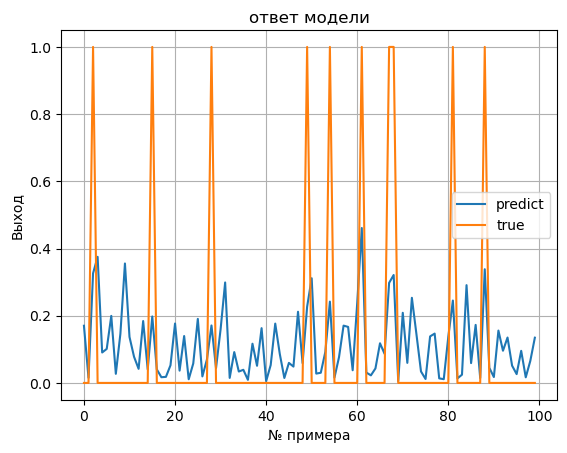

In [47]:
plt.plot(preds[:100], label='predict')
plt.plot(y_test.values[:100], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('Выход')
plt.legend()
plt.grid('On')
plt.show()

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.615462, F-Score=nan, Precision=0.000, Recall=0.000


C:\Temp\ipykernel_9120\3063505166.py:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


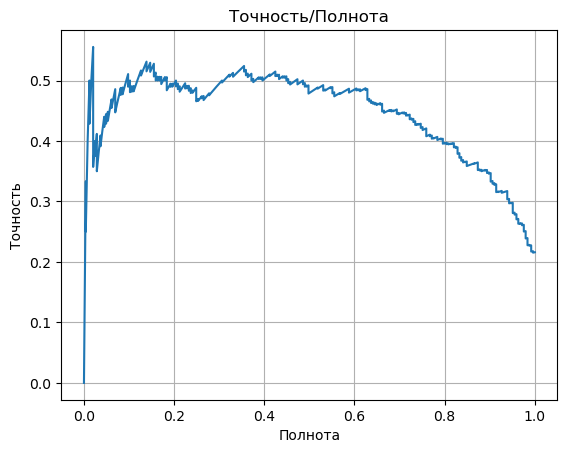

In [49]:
plt.plot(recall[:-1], precision[:-1])
plt.title('Точность/Полнота')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.grid('On')
plt.show()

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1754    1]
 [ 245    0]]


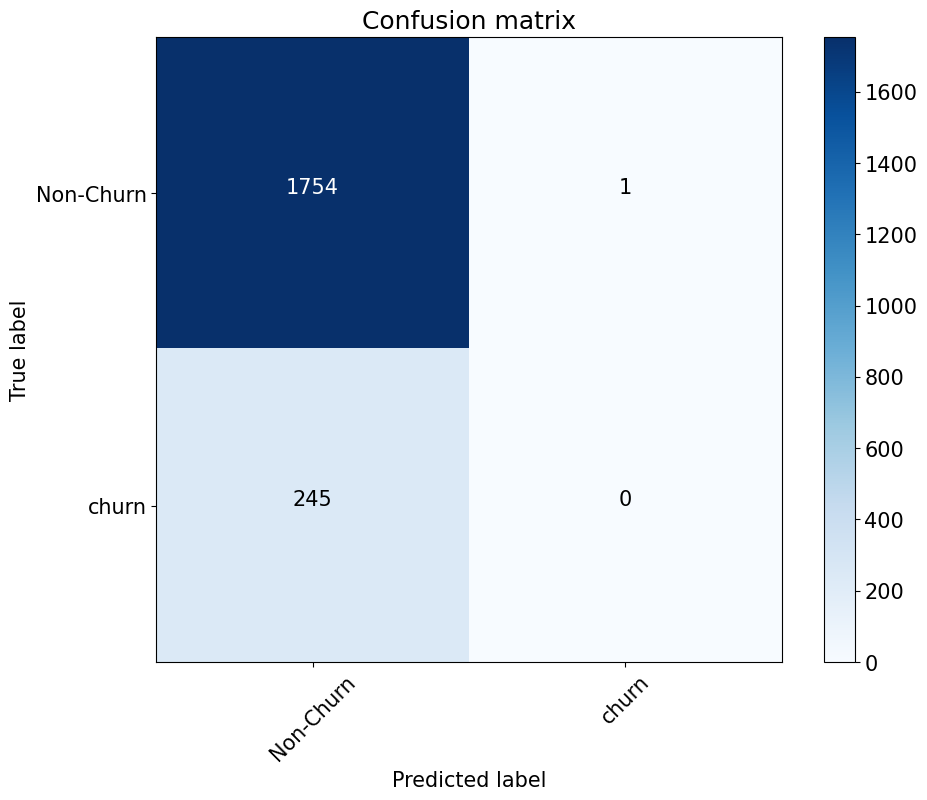

In [51]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Тут опасно использовать roc_auc, поскольку датасет сильно несбалансированный. Мало оттока по сравнению с неоттоком.

In [52]:
roc_auc_score(y_test, preds)

0.8943078085935228

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Вопросы

Чем fit отличается от fit_transform?

1. fit_transform не может быть у классификаторов
2. fit это только обучение модели, а fit_transform это обучение + применение -> результат. 

### Дополнение по кластер-анализу:

* обучение без учителя
* может быть одноуровневым или иерархическим

Варианты из sklearn:
* Агломеративное - AgglomerativeClustering():гиперпараметр - число групп n_clusters,
* DBSCAN - DBSCAN(): метрика, размер сферы (eps) и минимальное число соседей min_samples,
* K средних - Kmeans(): гиперпараметр - число групп n_clusters, метрика.

In [53]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
import seaborn as sns

In [54]:
X_train.shape

(6000, 20)

In [55]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)
y_kmeans = kmeans.predict(X_train)

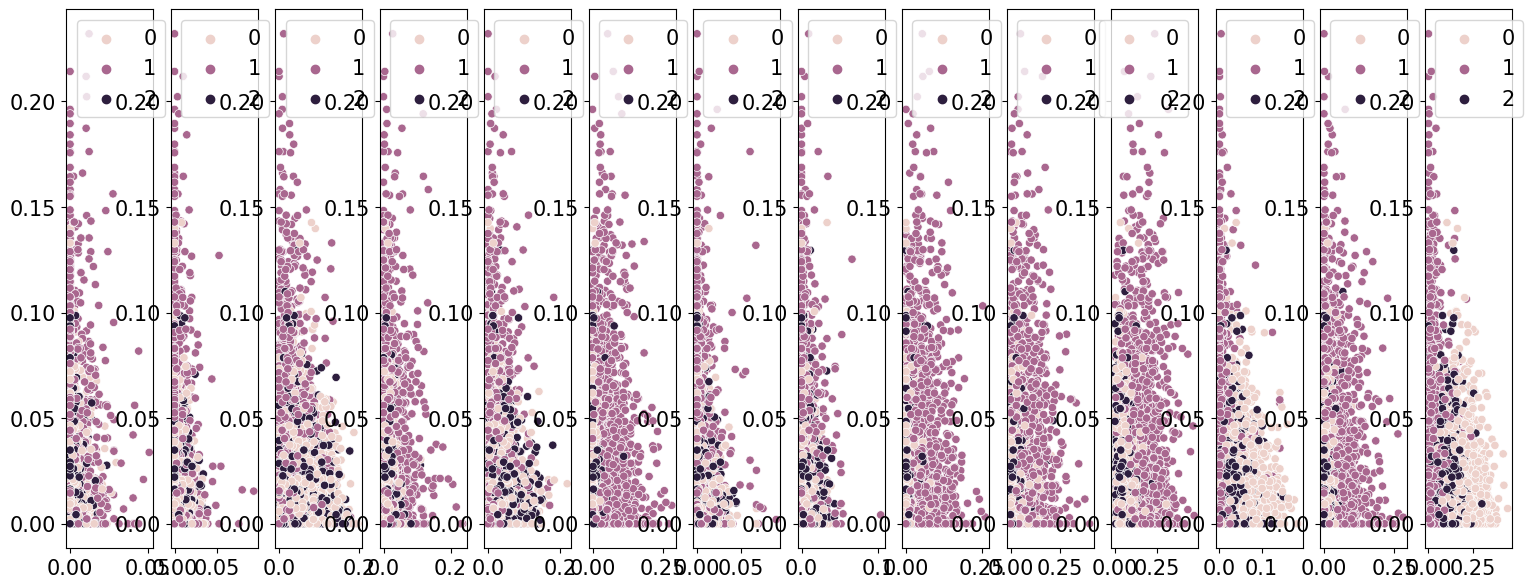

In [56]:
nn = N_topics-5
plt.figure(figsize=(20, 7))
for i in range(1, nn):
    plt.subplot(1, nn, i)
    sns.scatterplot(x=X_train.iloc[:,i].values, y=X_train.iloc[:, 0].values, hue=y_kmeans)
plt.show()

In [57]:
EPS = []
for eps in np.linspace(0.01, 1.0, 50):
    x_cluster = DBSCAN(eps=eps, min_samples=15).fit(X_train)
    EPS.append([eps, len(set(x_cluster.labels_)), np.sum(x_cluster.labels_ == -1)])
EPS = np.array(EPS)

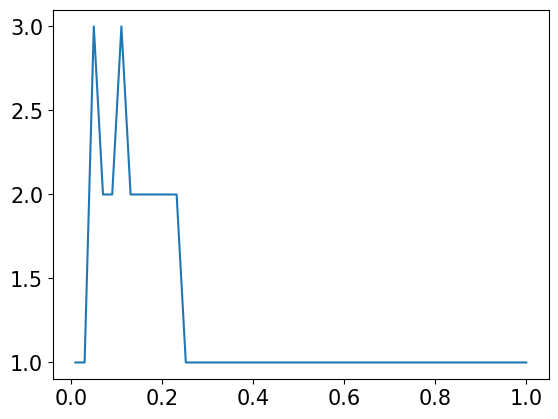

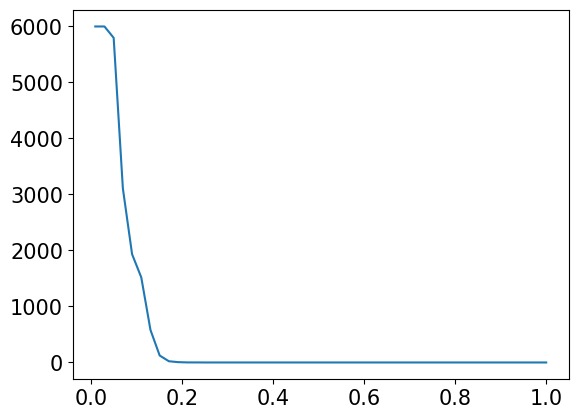

In [58]:
plt.plot(EPS[:,0], EPS[:,1])
plt.show()
plt.plot(EPS[:,0], EPS[:,2])
plt.show()

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk
5. etc

---